## PREDICTING SALE PRICES OF HOMES IN AMES, IOWA

### Problem Statement
The prediction of housing prices in any city is extremley important to all parties involved in the transaction. If buyers from another city want to move into Ames, they will need to predict what prices will be to best facilitate their move into their new home. On the other hand, houseowners and real estate agents wanting to sell a unit will need to know what the best price is that they can list the home at.

### Summary

The primary target of this project is to make accurate predictions of housing prices in Ames, Iowa.

Structure:

**Notebook 1:**
1) Data Cleaning,

2) EDA & Feature Engineering (Combined)

**Notebook 2:**
1) Feature Engineering & Modelling (Combined)

2) Evaluation

The training set used in this project involves about 2,000 samples (82 columns total -  23 nominal, 23 ordinal, 14 discrete, and 20 continuous variables)
Data is initially cleaned by dropping features with large amounts of nulls and points with obvious outliers.

Data is later further separated into features types and explored using various plot types for the sake of visualization.

Categorical features are either one-hot-encoded or label-encoded.
This is later further split into training and testing sets, and fitted to Linear, Ridge, and Lasso regressions. The metric used to assess these models is the Root Mean Squared Error (RMSE), and the best performing model would have the lowest RMSE.

## Imports and Data Cleaning

In [70]:
#importing necessary packages for Data Cleaning & EDA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [71]:
train = pd.read_csv('./datasets/train.csv')

In [72]:
train.shape

(2051, 81)

In [73]:
train.dtypes

Id                int64
PID               int64
MS SubClass       int64
MS Zoning        object
Lot Frontage    float64
                 ...   
Misc Val          int64
Mo Sold           int64
Yr Sold           int64
Sale Type        object
SalePrice         int64
Length: 81, dtype: object

In [74]:
#renaming all columns to lowercase/replacing spaces with '_' for 
#consistency
train.columns = [x.lower().replace(' ','_') for x in train.columns]

In [75]:
#checking if column renaming works:
train.head(1)

,id,pid,ms_subclass,ms_zoning,lot_frontage,lot_area,street,alley,lot_shape,land_contour,...,screen_porch,pool_area,pool_qc,fence,misc_feature,misc_val,mo_sold,yr_sold,sale_type,saleprice
0,109,533352170,60,RL,NaN,13517,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,3,2010,WD,130500


### Handling Null Values:


In general, columns containing more than 85% null values will be removed.

In [76]:
train.replace(0,np.nan, inplace=True)
train.isnull().sum()

id                 0
pid                0
ms_subclass        0
ms_zoning          0
lot_frontage     330
                ... 
misc_val        1986
mo_sold            0
yr_sold            0
sale_type          0
saleprice          0
Length: 81, dtype: int64

In [77]:
#sorting the columns with the highest number of null values in
#descending order
null_vals = pd.DataFrame([train.isnull().sum()]).T

In [78]:
null_vals = null_vals.rename(columns={0:"sum_of_nulls"})

In [79]:
#calculating percentage of nulls over total rows:
null_vals['missing_pct']=null_vals.apply(lambda row: (row['sum_of_nulls']/len(train))*100, axis=1)

In [80]:
#sorting the features with highest missing % in descending order
null_vals.sort_values(by='missing_pct',ascending=False).head(15)

,sum_of_nulls,missing_pct
pool_qc,2042,99.561190
pool_area,2042,99.561190
3ssn_porch,2025,98.732326
low_qual_fin_sf,2018,98.391029
misc_val,1986,96.830814
misc_feature,1986,96.830814
bsmt_half_bath,1925,93.856655
alley,1911,93.174061
screen_porch,1870,91.175037
bsmtfin_sf_2,1804,87.957094


In [81]:
train['pool_area'].replace(0,np.nan, inplace=True)
train['pool_area'].isnull().value_counts()

True     2042
False       9
Name: pool_area, dtype: int64

In [82]:
#Checking that non-null rows of Pool Area are the same non-null rows of
#Pool QC so that we know  they correspond to each other
train[(train['pool_area'].notna()) | (train['pool_qc'].notna())][['pool_area','pool_qc']]

,pool_area,pool_qc
52,519.0,Fa
657,576.0,Gd
761,800.0,Gd
952,228.0,Ex
960,480.0,Gd
1130,648.0,Fa
1249,738.0,Gd
1635,368.0,TA
1875,561.0,TA


### Columns with a high count of null values:

1) pool_qc - Pool Quality - Ordinal (2042 null values)
   -> Pool QC is non-null only in rows where Pool Area is also non-null.
   This column will be **dropped**. Pool QC is dependent on Pool Area        being a non-null value. There    are only a limited number of      datapoints that have pools, and as checked above, these are the same values that are non-null in pool_qc.
   
2) pool_area - This will also be **dropped**, as 2042 datapoints do not have    pools.

3) 3ssn_porch - 98pct null values - to be **dropped**
  
4) low_qual_fin_sf - Low quality finished square feet (all floors) - 98% null values - feature to be **dropped**

5) misc_val - 97% null vals - feature to be **dropped**

6) misc_feature - Nominal (1986 null values) -> This column will be **dropped**, as there isn't a lot of              information    on    Misc Features and majority (96.8%) of these data      points are left blank.

7) bsmt_half_bath - Bsmt Half Bath (Discrete) -> 94% null - this column will be **dropped**

8) alley - Alley Access Type - Nominal (1911 null values)
   -> This column will be **dropped**, as a large proportion (93.2%) of the    total dataset is recorded as Null - No Alley Access
   
9) fence - Fence Quality - Ordinal (1651 null values)
   -> This column will **dropped**, as only about 20% of datapoints have
   this value as a non-null.
   
10) fireplace_qu - Fireplace Quality - Ordinal (1000 null values)
    -> This column will **not be dropped yet**, but instead go through
    ordinal encoding.

In [83]:
#removing columns defined above:
train.drop(columns=['pool_qc','pool_area','3ssn_porch','low_qual_fin_sf','misc_val',
                    'misc_feature','bsmt_half_bath','alley','fence'], inplace=True)

In [84]:
train.shape

(2051, 72)

# Handling Outliers

Outliers to look out for:

1) Gr Liv Area (Continuous): Above grade (ground) living area(sqft) -> Outliers are seen at above 4,000sqft. 
These values will be dropped

2) Lot Area (Continuous): Lot size in square feet -> as shown below, outliers with lot areas above 75,000sqft 
will be dropped.


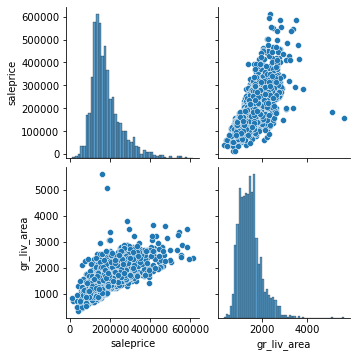

In [86]:
#plotting Sale Price against Ground living area in square feet
saleprice_grlivarea = train[['saleprice','gr_liv_area']]
sns.pairplot(saleprice_grlivarea);

In [88]:
#Filtering for and removing houses with more than 4000 sqft - outliers
train[train['gr_liv_area']>4000]

,id,pid,ms_subclass,ms_zoning,lot_frontage,lot_area,street,lot_shape,land_contour,utilities,...,garage_cond,paved_drive,wood_deck_sf,open_porch_sf,enclosed_porch,screen_porch,mo_sold,yr_sold,sale_type,saleprice
960,1499,908154235,60,RL,313.0,63887,Pave,1,Bnk,4,...,3.0,2,214.0,292.0,NaN,NaN,1,2008,New,160000
1885,2181,908154195,20,RL,128.0,39290,Pave,3,Bnk,4,...,3.0,2,546.0,484.0,NaN,NaN,10,2007,New,183850


In [89]:
#dropping above outliers
train.drop(train.index[[960,1885]], inplace=True)

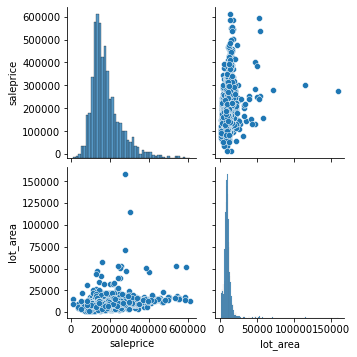

In [90]:
#checking outliers for lot area
saleprice_lotarea = train[['saleprice','lot_area']]
sns.pairplot(saleprice_lotarea);

In [91]:
#identifying outliers - threshold used: 75,000sqft
train[train['lot_area']>75000]

,id,pid,ms_subclass,ms_zoning,lot_frontage,lot_area,street,lot_shape,land_contour,utilities,...,garage_cond,paved_drive,wood_deck_sf,open_porch_sf,enclosed_porch,screen_porch,mo_sold,yr_sold,sale_type,saleprice
471,2116,906426060,50,RL,NaN,159000,Pave,2,Low,4,...,3.0,2,NaN,98.0,NaN,NaN,6,2007,WD,277000
694,2072,905301050,20,RL,NaN,115149,Pave,2,Low,4,...,3.0,2,380.0,48.0,NaN,NaN,6,2007,WD,302000


In [92]:
#dropping above outliers
train.drop(train.index[[471,694]], inplace=True)

In [93]:
train.shape

(2047, 72)

In [94]:
#replacing null values with 0s
train.replace(np.nan, 0, inplace=True)

# EDA & SOME FEATURE ENGINEERING ##

### Ordinal Encoding for Ordinal Features

Ordinal feature types are manually assigned to numeric labels here, as our models cannot take in non-numeric data.

In [85]:
train.replace(to_replace = {
    'lot_shape':{'Reg': 4,'IR1': 3,'IR2': 2,'IR3': 1},
    'utilities':{'AllPub':4,'NoSewr':3,'NoSeWa':2,'ELO':1},
    'land_slope':{'Gtl':3,'Mod':2,'Sev':1},
    'bsmt_cond': {'Ex': 5, 'Gd': 4, 'TA':3, 'Fa':2, 'Po': 1, 'NA': 0},
    'bsmt_exposure': {'Gd': 4, 'Av':3, 'Mn':2, 'No': 1, 'NA': 0},
    'bsmt_qual': {'Ex': 5, 'Gd': 4, 'TA':3, 'Fa':2, 'Po': 1, 'NA': 0},
    'exter_qual': {'Ex': 5, 'Gd': 4, 'TA':3, 'Fa':2, 'Po': 1, 'NA': 0},
    'exter_cond': {'Ex': 5, 'Gd': 4, 'TA':3, 'Fa':2, 'Po': 1, 'NA': 0},
    'heating_qc': {'Ex': 5, 'Gd': 4, 'TA':3, 'Fa':2, 'Po': 1, 'NA': 0},
    'bsmtfin_type_1': {'GLQ':6, 'ALQ':5,'BLQ':4,'Rec':3,'LwQ':2,'Unf':1,'NA':0},
    'bsmtfin_type_2': {'GLQ':6, 'ALQ':5,'BLQ':4,'Rec':3,'LwQ':2,'Unf':1,'NA':0},
    'electrical':{'SBrkr':5,'FuseA':4,'FuseF':3,'FuseP':2,'Mix':1},
    'kitchen_qual':{'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1},
    'functional':{'Typ':8,'Min1':7,'Min2':6,'Mod':5,'Maj1':4,'Maj2':3,'Sev':2,'Sal':1},
    'fireplace_qu': {'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1,'NA':0},
    'garage_finish':{'Fin':3,'RFn':2,'Unf':1,'NA':0},
    'garage_qual':{'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1,'NA':0},
    'garage_cond':{'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1,'NA':0},
    'paved_drive':{'Y':2,'P':1,'N':0}},
    inplace=True   
)

In [96]:
train.to_csv('./datasets/train_cleaned.csv')

In [97]:
train.shape 

(2047, 72)

**BOXPLOTS & COUNTPLOTS FOR NOMINAL FEATURES**

In this section, nominal features will be separated into arbitrary types of nominal features and plots/analyses will be made accordingly.

Generally, if a boxplot does not have a good measure of spread, such as the interquartile range is similar across categories,or if a countplot is highly skewed to a limited number of category types/there is a lack of variance across categories in that feature, we will drop the feature as it is not indicative enough of a specific result.

In [98]:
#function to plot boxplots & countplots beside each other

def subplot_boxcountplot(dataframe, list_of_features, figsize=(20,10)):
    fig, ax = plt.subplots(nrows=len(list_of_features), 
                           ncols=2, 
                           figsize=figsize)
    ax=ax.ravel()
    
    for i, feature in enumerate(list_of_features):
        # left col: boxplot
        sns.boxplot(
            ax=ax[2*i],
            data=dataframe,
            x=feature,
            y='saleprice',
            orient='v',
            linewidth=1,
            palette='husl'
        );
        #rotation necessary especially for features with many categories
        ax[2*i].set_xticklabels(ax[2*i].get_xticklabels(),rotation=45, size=15)
        ax[2*i].set_xlabel(feature, fontsize = 20)
        ax[2*i].set_ylabel('Sale Price', fontsize = 20)

        # right col: countplot
        sns.countplot(x=feature,
                      ax=ax[2*i+1],
                      data=dataframe,                      
                      palette='husl',      
                     );
        #rotation necessary especially for features with many categories        
        ax[2*i+1].set_xticklabels(ax[2*i+1].get_xticklabels(),rotation=45, size=15)
        ax[2*i+1].set_xlabel(feature, fontsize = 20)
        ax[2*i+1].set_ylabel("Count", fontsize = 20)
        fig.tight_layout(pad=3.0)
        
    return fig,ax

**FEATURES LIST 1 - MS SubClass**

**ms_subclass** - ms_subclass seems to have quite a large variance across different categories. 

Thus, we will regroup certain categories with similar interquartile ranges on price with the following groups:

| BIN No. | Subclasses |
| --- | --- |
|bin1|20 & 75|
|bin2|30|
|bin3|60|
|bin4|70|
|bin5|80 & 85|
|bin6|50 & 90|
|bin7|120|
|bin8|190 & 40|
|bin9|160 & 180|
|bin10|All other subclasses (45 & 150)|

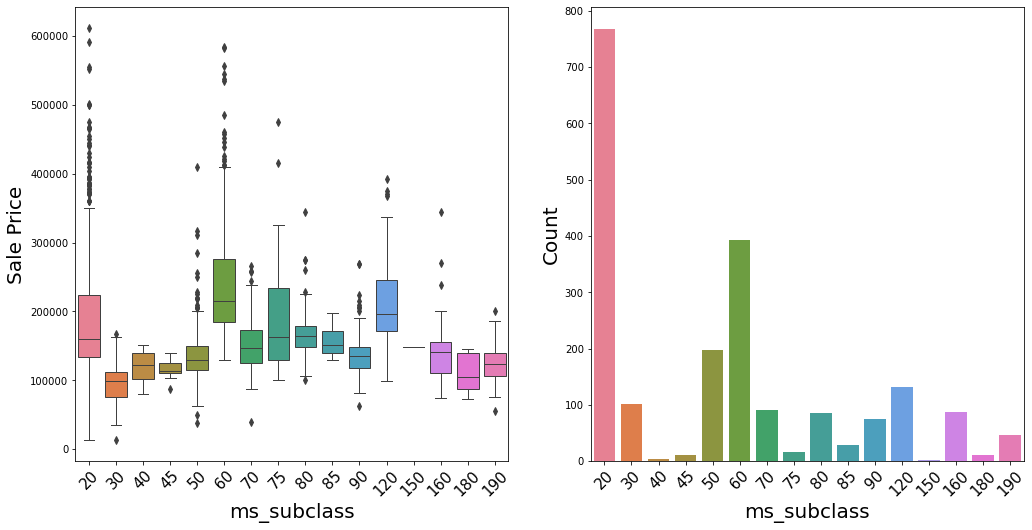

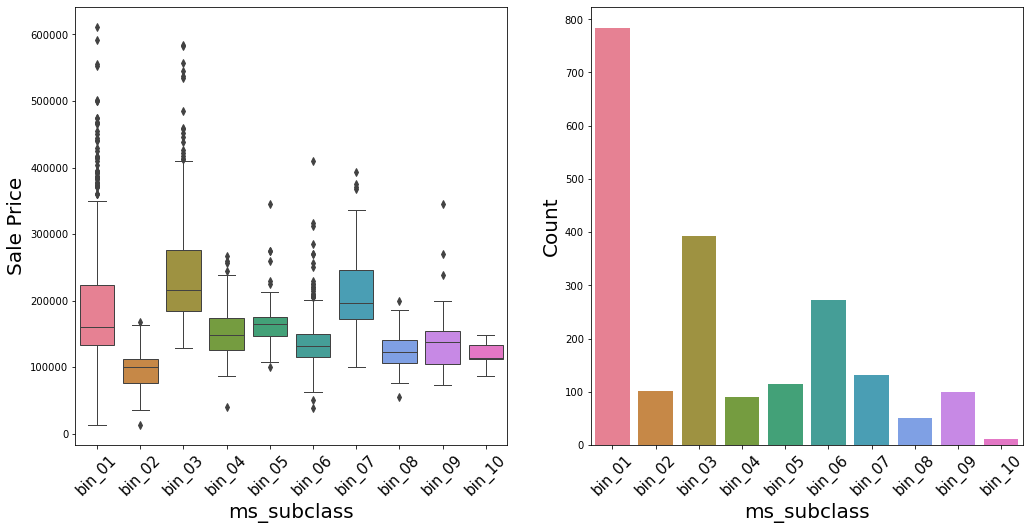

In [99]:
#plotting the original box & count plots of ms_subclass
features_list1 = ['ms_subclass']
subplot_boxcountplot(train, features_list1, figsize=(15,8));

#identifying respective bins (categories of similar interquartile ranges put together)
group = {20:'bin_01',75:'bin_01',30:'bin_02',60:'bin_03', 
         70:'bin_04',80:'bin_05',85:'bin_05',50:'bin_06',
         90:'bin_06',120:'bin_07',190:'bin_08',40:'bin_08', 
         160:'bin_09',180:'bin_09',45:'bin_10',150:'bin_10'}

#assigning the regrouped bins & overwriting existing columns
train['ms_subclass'] = train.apply(lambda row: group[row['ms_subclass']] 
                                   if (row['ms_subclass'] in group) 
                                   else row['ms_subclass'], axis=1)
train['ms_subclass'].value_counts()

#sorting values & plotting regrouped box&count plot:
df = train.sort_values('ms_subclass', ascending=True)
subplot_boxcountplot(df, ['ms_subclass'], figsize=(15,8));


**FEATURES LIST 2 - Lot Config:**

**lot_config** - Lot Configuration. We will leave this feature in. Although datapoints are predominantly Inside homes, we see that the interquartile range is quite different across Culdesac type homes and inside/corner type units. These categories will be One-Hot-Encoded individually.

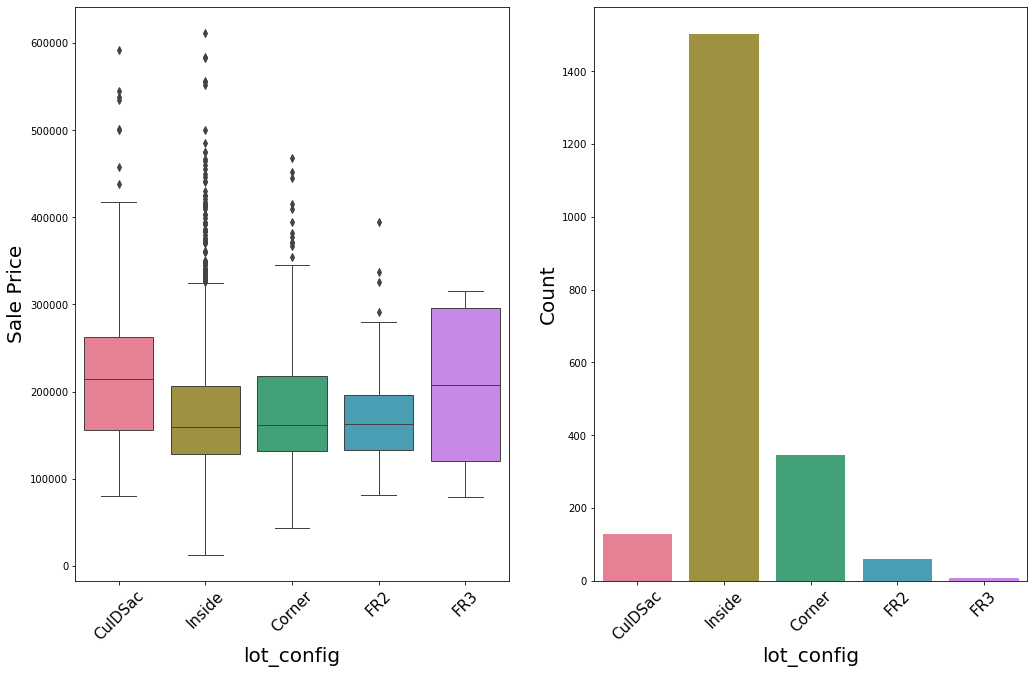

In [100]:
features_list2 = ['lot_config']
subplot_boxcountplot(train, features_list2, figsize=(15,10));


**FEATURES LIST 3 - Land Contour, MS Zoning, Street:**

**land_contour** - Flatness of property. Most data points are levelled. The **land_contour** feature will be dropped.

**ms_zoning** - Identifies the general zoning classification of the sale. Highly skewed to RL & RM zone types. The **ms_zoning** feature will be dropped.

**street** - Street - Type of road access to property - highly skewed & majority of data points have Pavement. The **street** feature will be dropped.

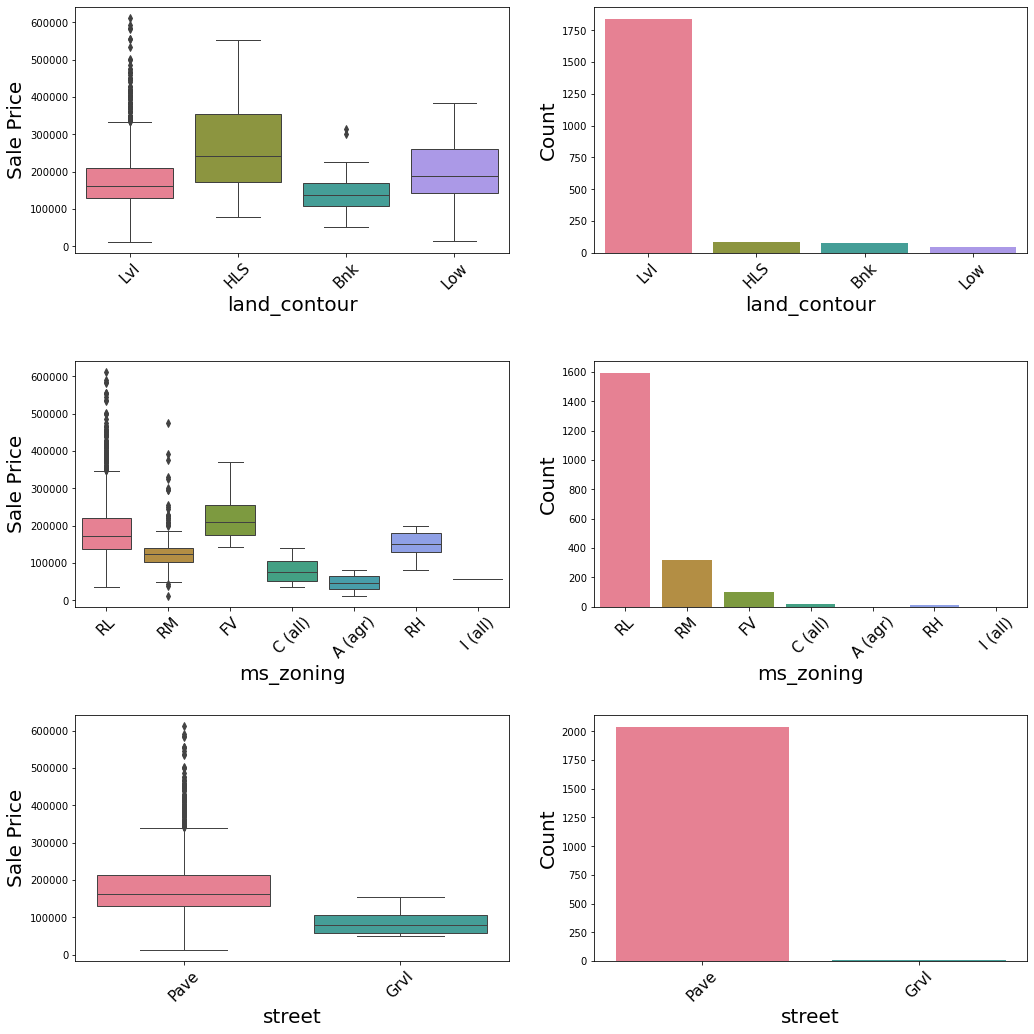

In [101]:
features_list3 = ['land_contour','ms_zoning','street']
subplot_boxcountplot(train, features_list3, figsize=(15,15));

**FEATURES LIST 4 - Neighborhood:**

**neighborhood** - Physical locations within Ames city limits. We can see that there is a significant variance in price across different neighborhoods. We will keep this feature - categories will be one-hot encoded.

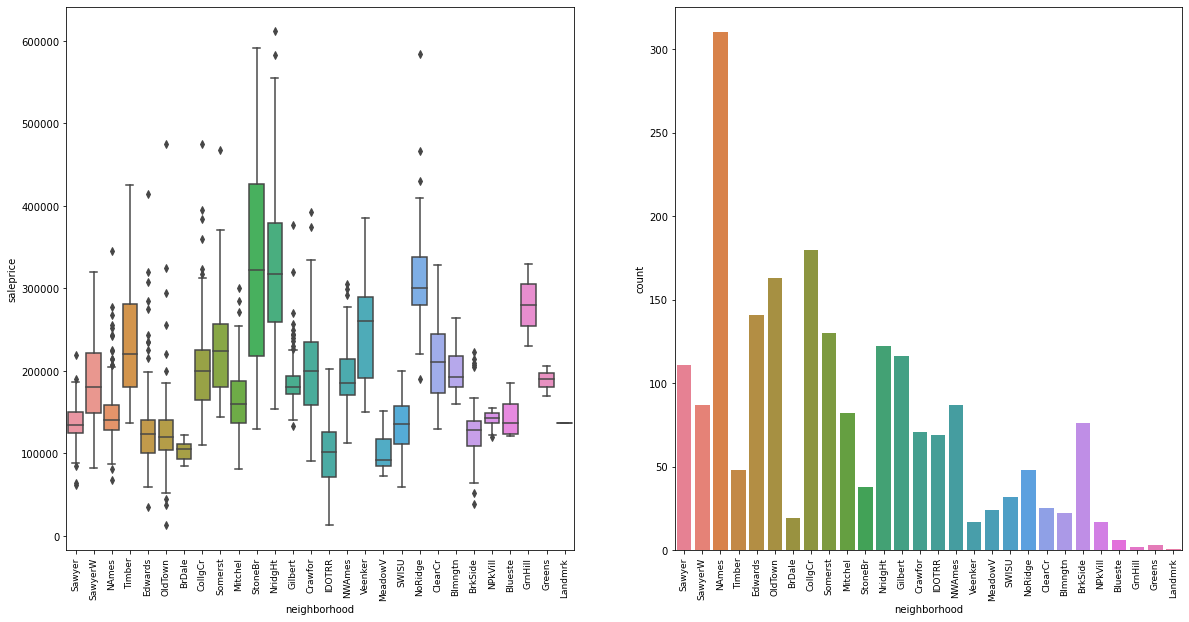

In [102]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
feat3_1 = sns.boxplot(x="neighborhood", y="saleprice", data=train, ax=ax[0]);
feat3_2 = sns.countplot(x="neighborhood", data=train, palette="husl");
feat3_1.set_xticklabels(feat3_1.get_xticklabels(),rotation=90, size=9);
feat3_2.set_xticklabels(feat3_2.get_xticklabels(),rotation=90, size=9);

**FEATURES LIST 5 - Condition 1, Condition 2:**

**condition_1** - Proximity to various conditions

**condition_2** - Proximity to various conditions (if more than one is present)
		
Both of these features will be dropped, as both had majority conditions marked as normal.

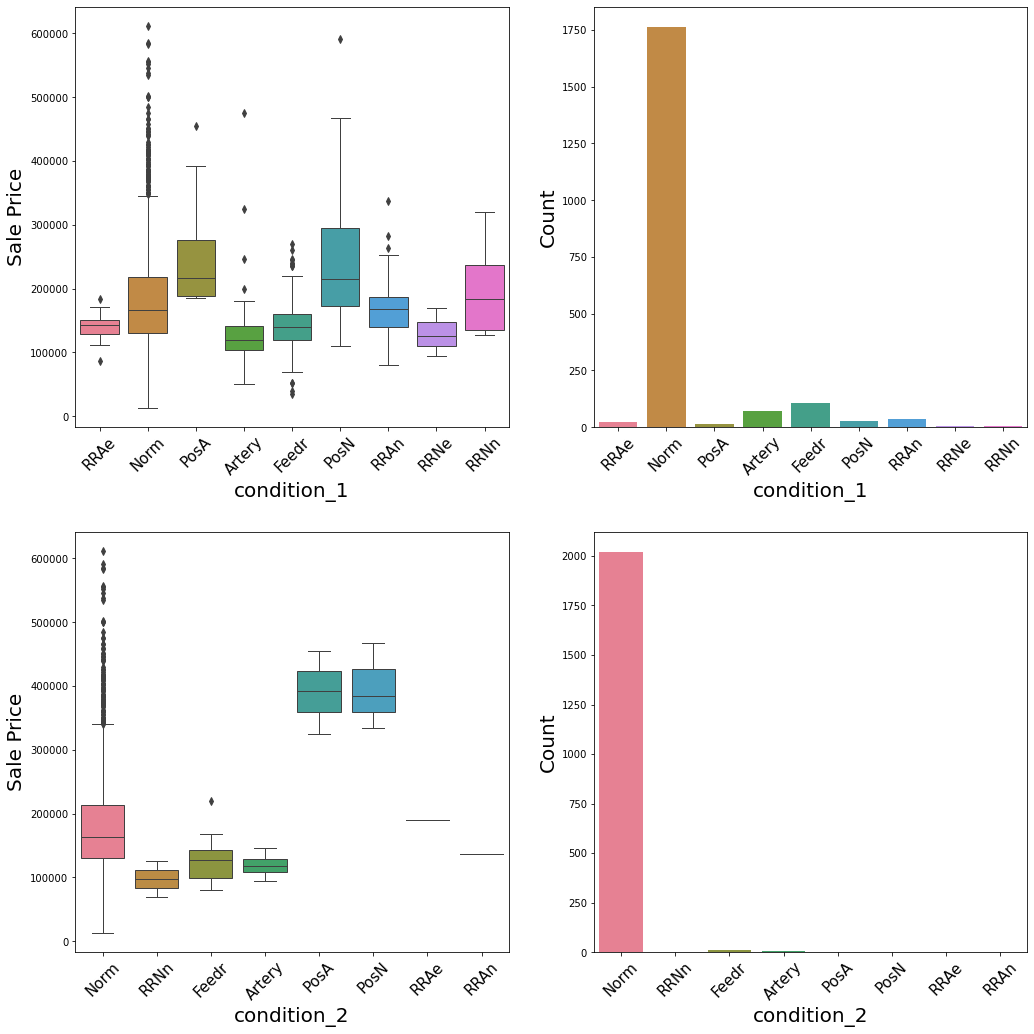

In [103]:
features_list5 = ['condition_1','condition_2']
subplot_boxcountplot(train, features_list5, figsize=(15,15));

**FEATURES LIST 6 - Building Type, House Style:**

**bldg_type** - Type of dwelling - This feature will be dropped. Although building type is usually indicative of price, most of the datapoints taken here were single-family homes.

**house_style** - Style of dwelling - This feature will be kept, and individual categories will be one-hot encoded. Quite a few data points were taken across 2 Storey, 1 Storey and 1.5 Storey (with second floor completed) homes. As we can see from the boxplot, Sale Prices also varied across dwelling styles.

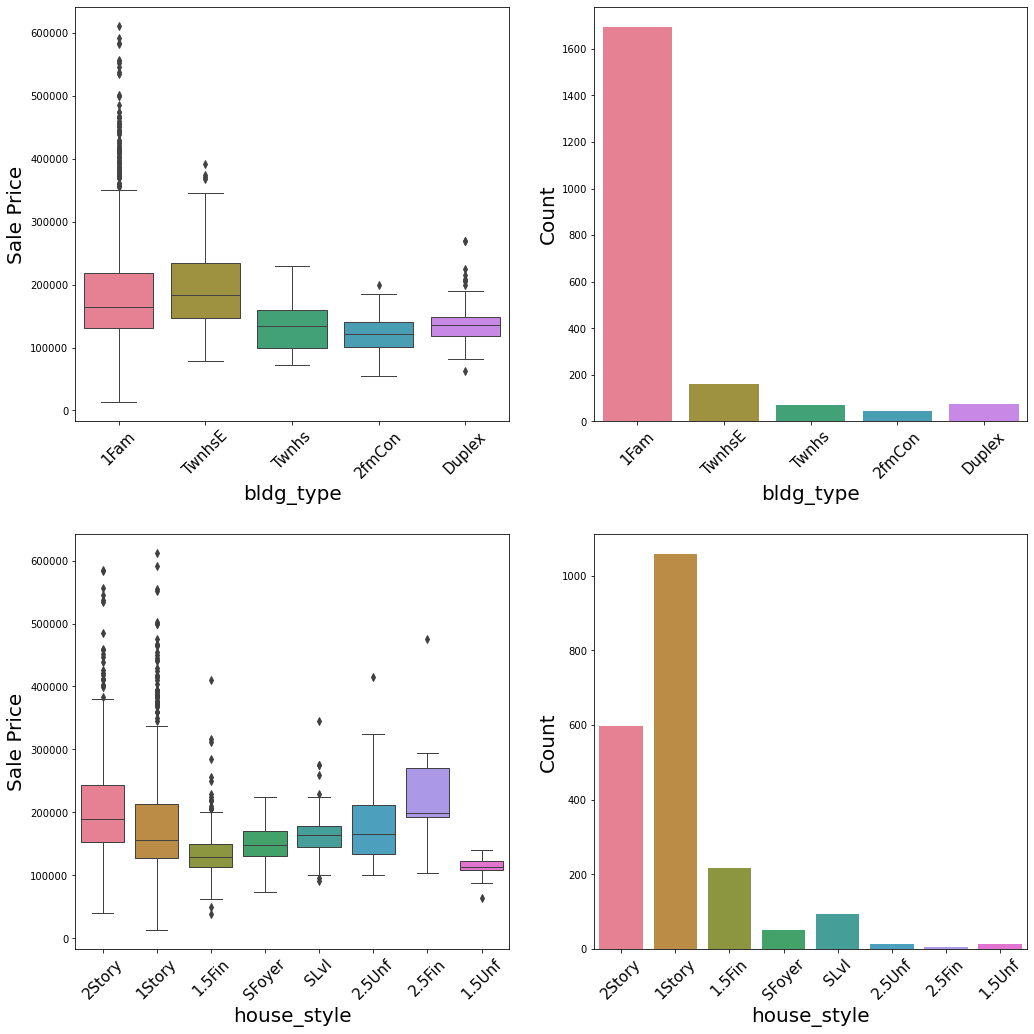

In [104]:
features_list6 = ['bldg_type','house_style']
subplot_boxcountplot(train, features_list6, figsize=(15,15));

In [105]:
train.drop(columns='bldg_type',inplace=True)

**FEATURES LIST 7 - Type of Roof, Roof Material:**

**roof_style** - Type of Roof

**roof_matl** - Roof material

Both these features will be removed. Interquartile ranges are quite similar across roof types. Although the boxplot for roof material categories have little to no overlapping ranges, based on the count plot we can see that the vast majority of datapoints were of CompShg (Standard (Composite) Shingle) types.

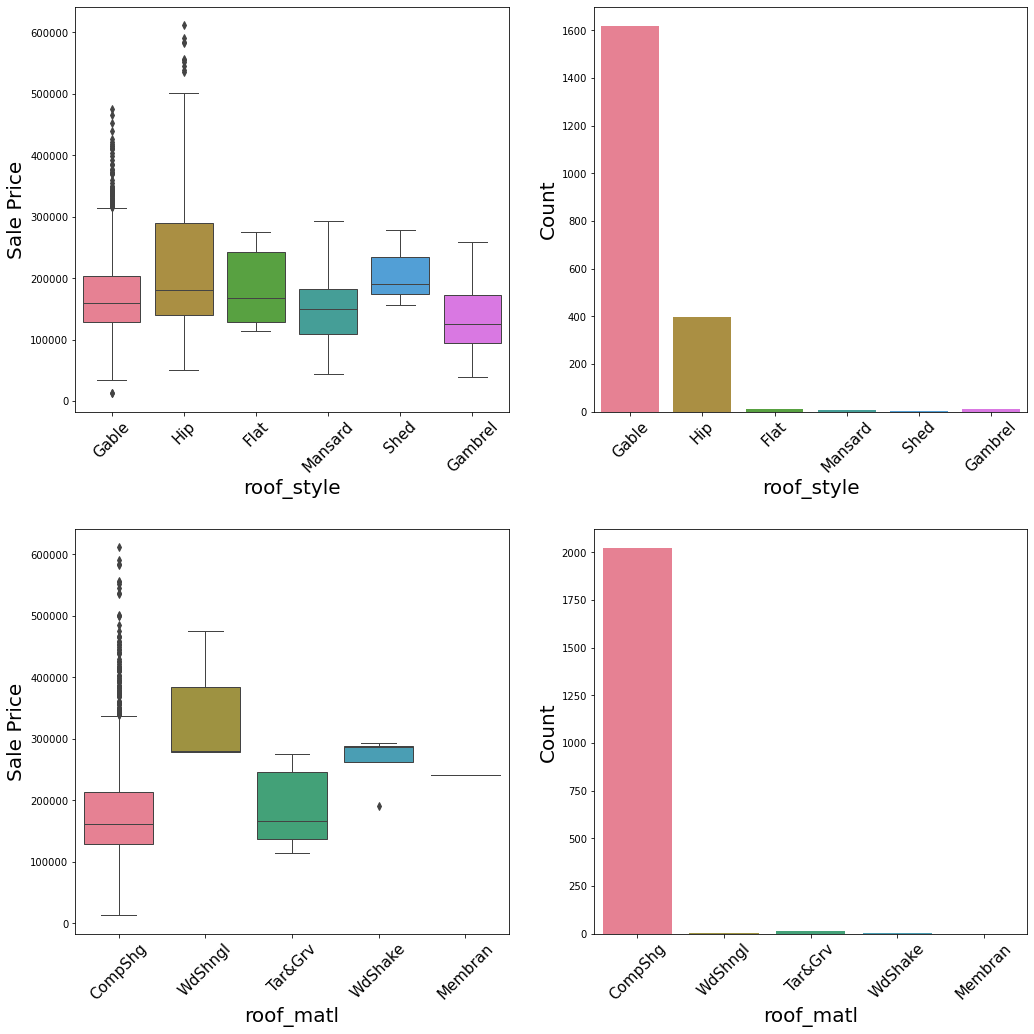

In [106]:
features_list7 = ['roof_style','roof_matl']
subplot_boxcountplot(train, features_list7, figsize=(15,15));

**FEATURES LIST 8 - Exterior 1st, Exterior 2nd:**

**exterior_1st** - Exterior covering on house

**exterior_2nd** - Exterior covering on house if more than 1 material.

Both these features will be removed.

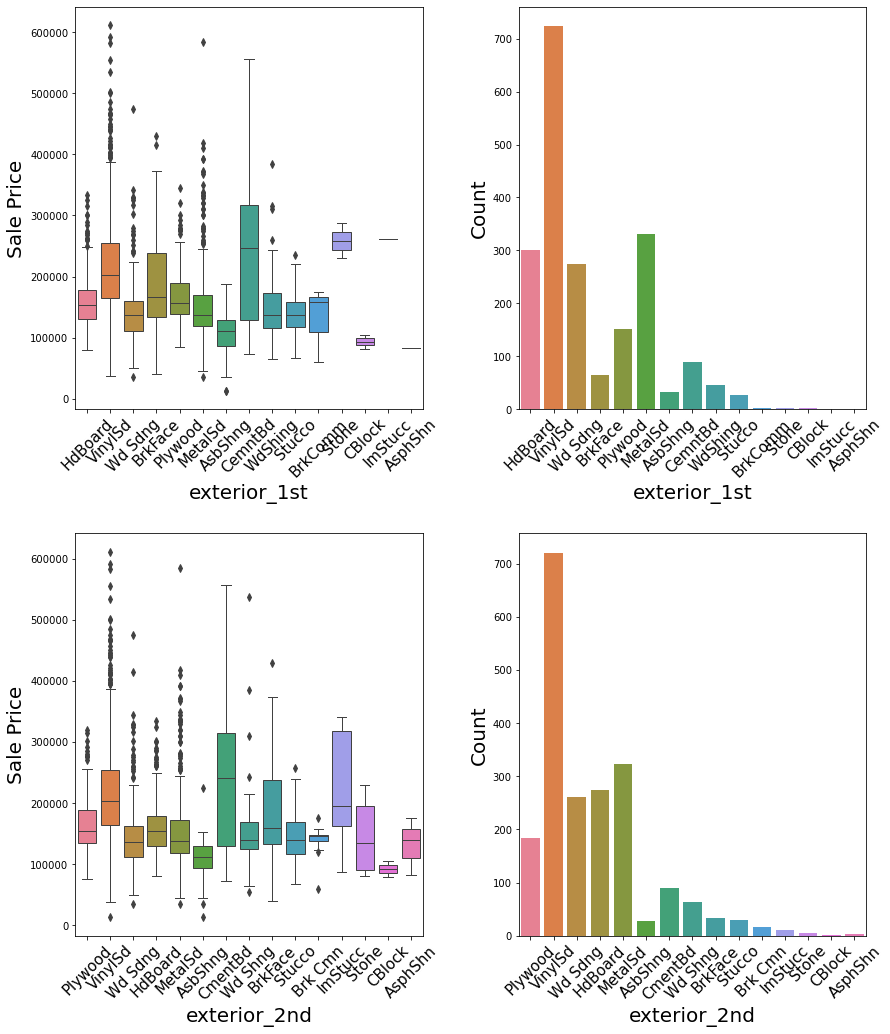

In [107]:
features_list8 = ['exterior_1st','exterior_2nd']

subplot_boxcountplot(train, features_list8, figsize=(13,15));

**FEATURES LIST 9 - Masonry Veneer Type, Type of Foundation, Garage Location**

**mas_vnr_type** - Exterior covering on house

**foundation** - Exterior covering on house if more than 1 material.

**garage_type** - Garage location

All these features will be kept and left for modelling & One Hot Encoding.

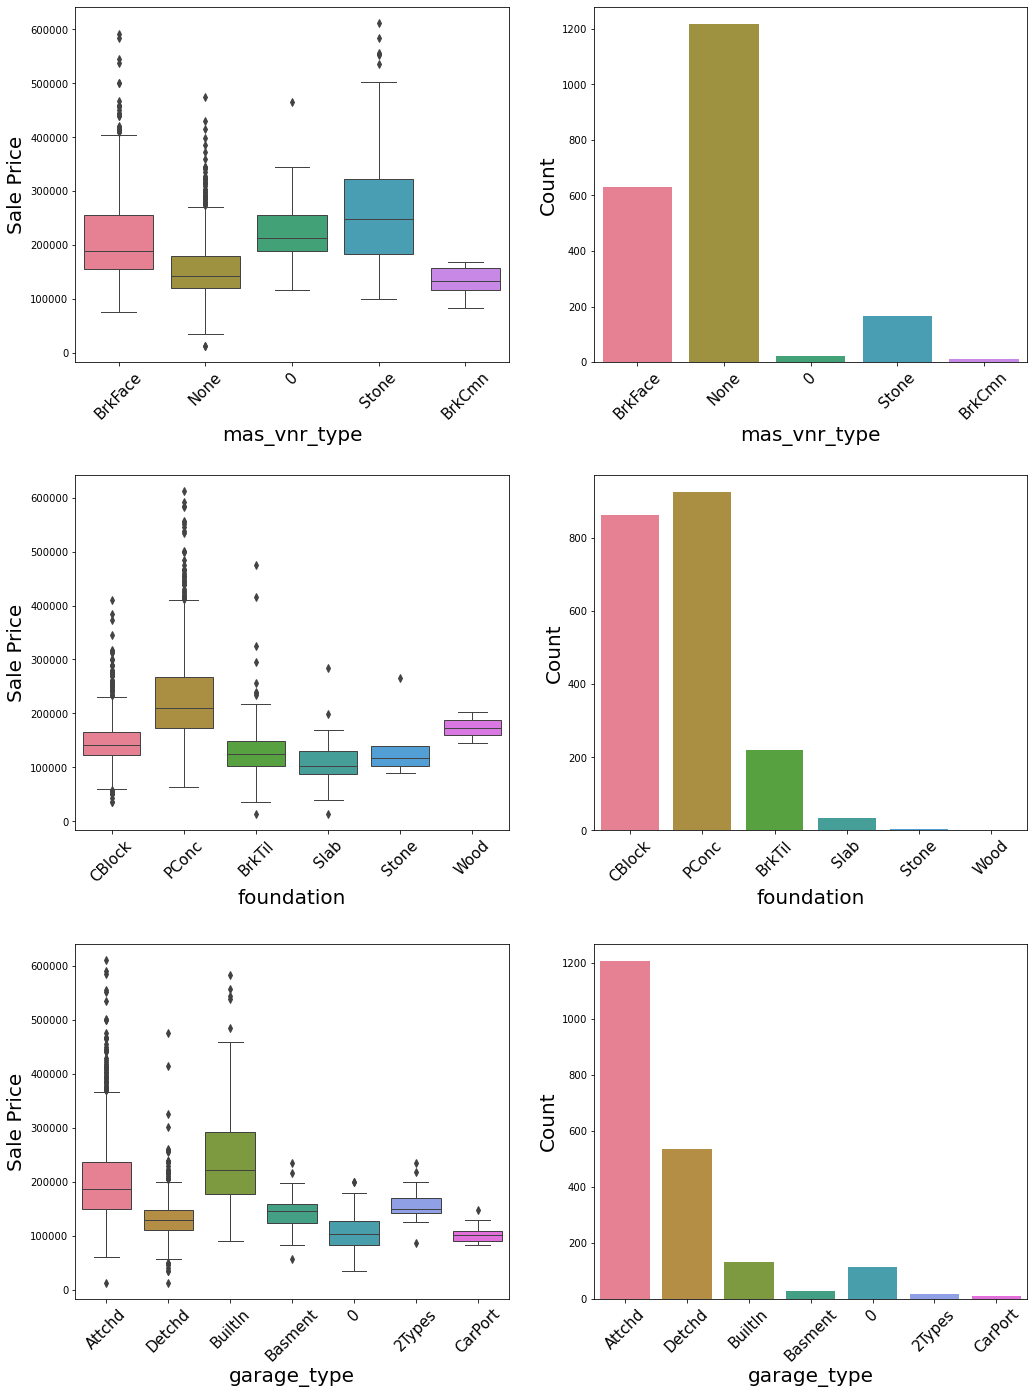

In [108]:
features_list9 = ['mas_vnr_type','foundation', 'garage_type']
subplot_boxcountplot(train, features_list9, figsize=(15,20));

**FEATURES LIST 10 - Heating, Central Air**

**Heating** - Type of heating - majority of points are gas. This column will be dropped.

**Central Air** - Central Air Conditioning - majority of homes in this dataset have central air conditioning. This column will also be dropped.

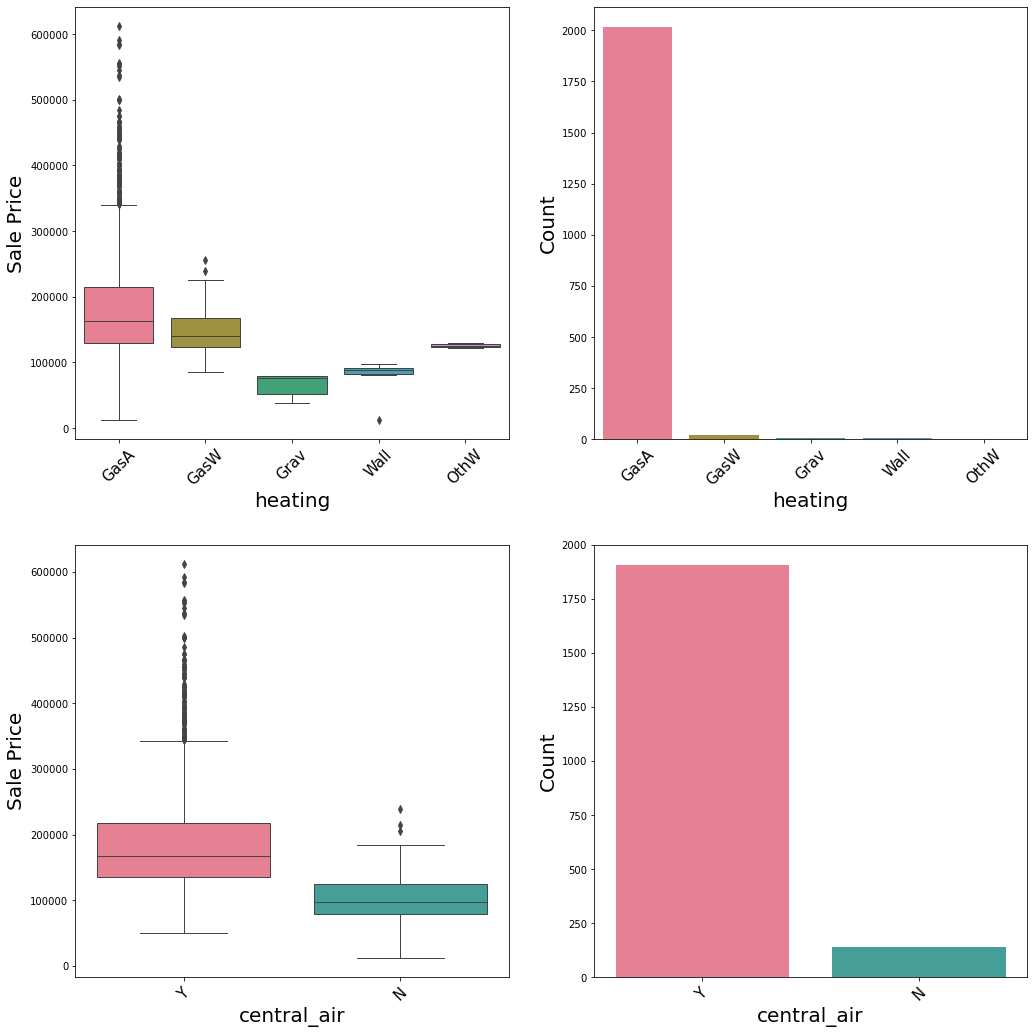

In [109]:
features_list10 = ['heating','central_air']
subplot_boxcountplot(train, features_list10, figsize=(15,15));

**FEATURES LIST 10 - Sale Type**

**sale_type** - Despite the variance in sale prices across different sale types as seen from the boxplot, the countplot is heavily left-skewed. Majority sales were of WD.(Conventional Warranty Deed) type. This feature will be dropped.

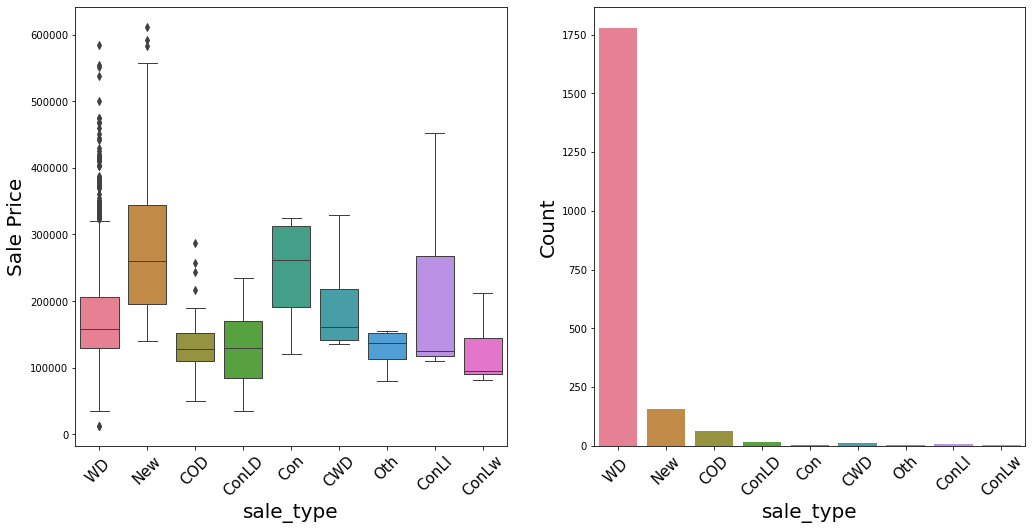

In [110]:
features_list11 = ['sale_type']
subplot_boxcountplot(train, features_list11, figsize=(15,8));

In [111]:
train.drop(columns=['ms_zoning','street',
                    'land_contour', 'condition_1',
                    'condition_2', 'roof_style',
                    'roof_matl','exterior_1st',
                    'exterior_2nd','heating',
                    'central_air'
                   ], inplace=True)

In [112]:
train.shape

(2047, 60)

## HEATMAPPING ##

### **Heatmap style:**
As the focus was features with higher magnitudes of (either positive of negative) correlations, the heatmaps are plotted in absolute values with darker colours indicating stronger positive or negative correlations.


In [113]:
#grouping variables into nominal, ordinal, discrete and continuous 
#(excluding those earlier dropped)


# All ordinal features except pool quality and fence quality, 
# which have already been dropped earlier
ordinal_cols =['lot_shape','utilities','land_slope','overall_qual',
          'overall_cond','exter_qual','exter_cond','bsmt_qual',
          'bsmt_cond','bsmt_exposure','bsmtfin_type_1','bsmtfin_type_2',
          'heating_qc','electrical','kitchen_qual','functional',
          'fireplace_qu','garage_finish','garage_qual','garage_cond',
          'paved_drive','pool_qc','fence']


nominal_cols = ['pid','ms_subclass','ms_zoning','street','alley'
           'land_contour','lot_config','neighborhood',
           'condition_1','condition_2','bldg_type',
           'house_style','roof_style','roof_matl',
           'exterior_1st','exterior_2nd','mas_vnr_type',
           'foundation','heating','central_air',
            'garage_type','misc_feature','sale_type']

discrete_cols = ['year_built','year_remod/add','bsmt_full_bath',
            'bsmt_half_bath','full_bath','half_bath',
            'bedroom_abvgr','kitchen_abvgr','totrms_abvgrd',
            'fireplaces','garage_yr_blt','garage_cars','mo_sold',
            'yr_sold']


cont_cols = ['lot_frontage','lot_area','mas_vnr_area',
             'bsmtfin_sf_1','bsmtfin_sf_2','bsmt_unf_sf',
             'total_bsmt_sf','1st_flr_sf','2nd_flr_sf',
             'low_qual_fin_sf','gr_liv_area','garage_area',
             'wood_deck_sf','open_porch_sf','enclosed_porch',
             '3ssn_porch','screen_porch','misc_val','saleprice']

#list of columns that have been dropped earlier
dropped_cols = ['pool_qc','pool_area','3ssn_porch','low_qual_fin_sf',
                'misc_val','misc_feature','bsmt_half_bath','alley',
                'fence','ms_zoning','street','land_contour','condition_1',
                'condition_2','roof_style','roof_matl','exterior_1st',
                'exterior_2nd','heating','central_air',]


In [114]:
def plot_heatmap(dataframe, features, dropped_columns):
    fig, ax = plt.subplots(figsize=(20,20))
    #this is to make sure we don't include features that have earlier been dropped
    #plotted in absolute value as we only want to select features based on high magnitudes (darker colours)
    sns.heatmap(abs(df[list(set(features) - set(dropped_columns))].corr()), 
                annot=True, cmap='YlGnBu',ax=ax, fmt=".2f")
    

### **Overview of heatmap for discrete features:**
Correlations worth noting:
- Bedrooms Above Grade & Total Rooms Above Grade (0.66)
- Year remod/add & Year Built (0.63)

The above 4 features are relatively strongly correlated compared to other discrete variables and are indicative of one another. If two features are very strongly correlated, one of the features may be dropped if both seem as predictive of the target variable. However, in this case the correlation factors are generally of quite weak magnitudes.

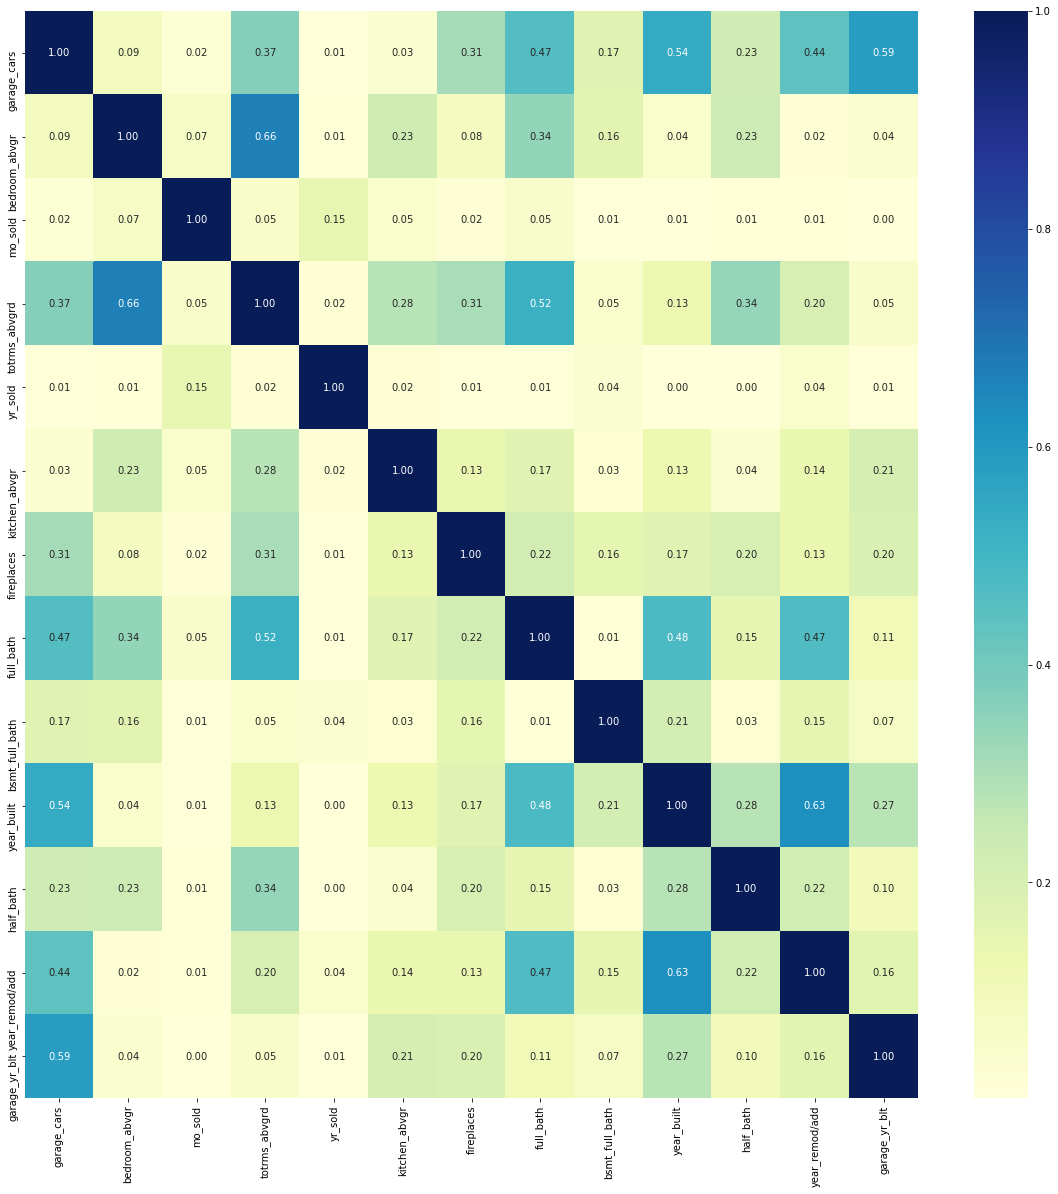

In [115]:
plot_heatmap(train, discrete_cols, dropped_cols)

### **Overview of heatmap for continuous features:**
Correlations worth noting:
    
- total_bsmt_sf & 1st_flr_sf (0.79)
- saleprice & gr_liv_area (0.72)
- 2nd_flr_sf & gr_liv_area (0.66)
- Several other features & saleprice

As total basement square footage & 1st floor square footage are quite highly correlated, we can choose to drop one of the features (**total_bsmt_sf**) here to reduce noise. 2nd_flr_sf & gr_liv_area are also quite highly correlated - we will drop **2nd_flr_sf**.

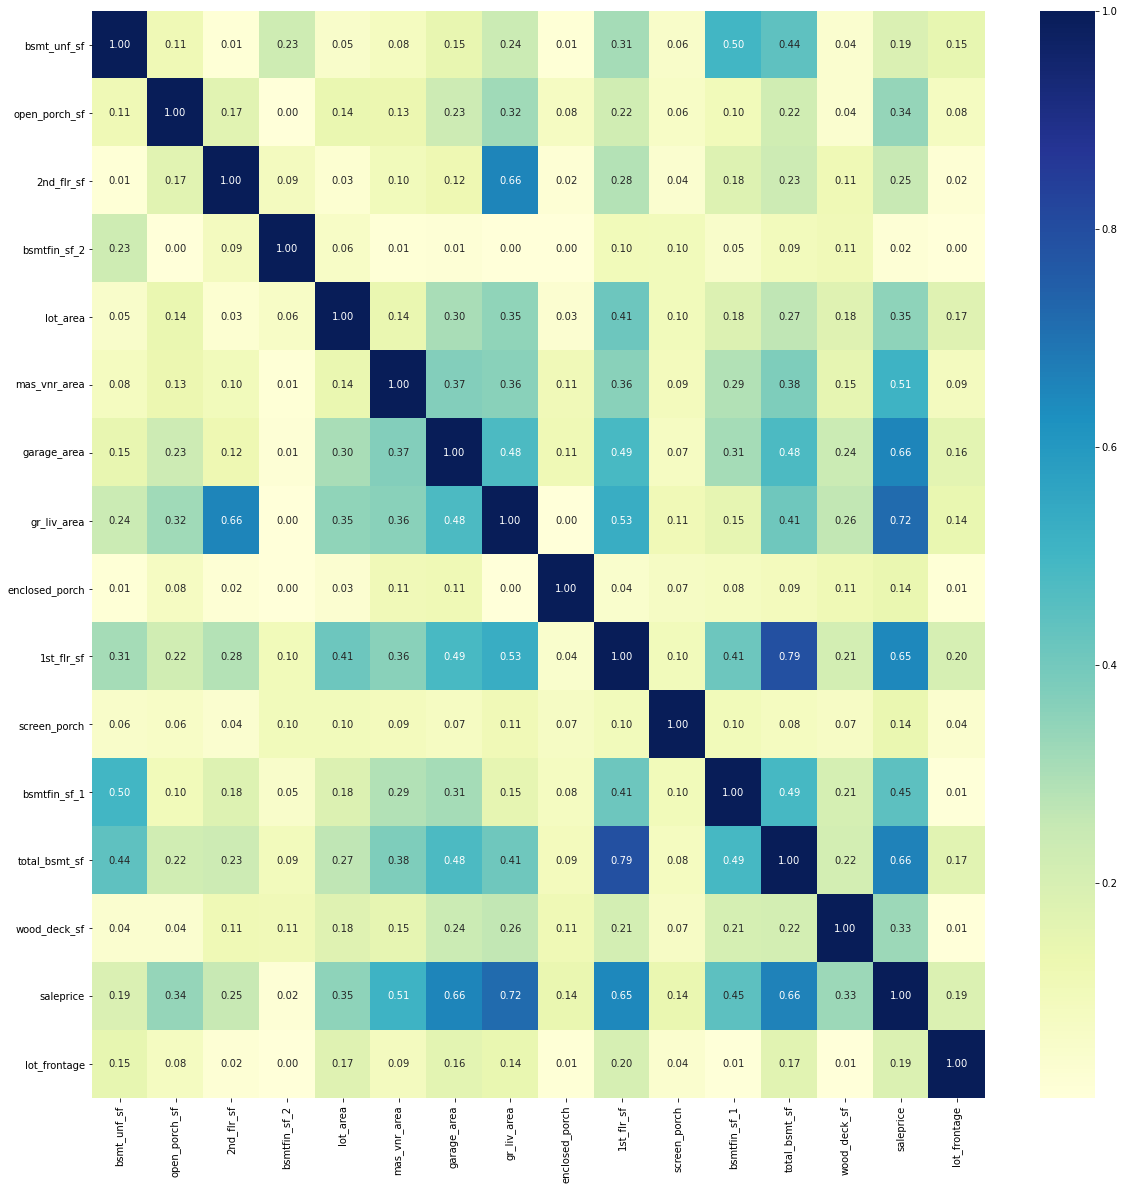

In [116]:
plot_heatmap(train, cont_cols, dropped_cols)

In [117]:
train.drop(columns=['2nd_flr_sf'], inplace=True)

### **Combined correlation plot for Discrete & Continuous Columns:**

Although hard to see, the darker boxes are obvious. The first plot shows an overview and the second plot shows a zoomed in version.

1) **garage_cars**: Size of garage in car capacity & **garage_area**: Size of garage in square feet are very highly correlated (0.9) - we can **drop garage_cars** here as the number of cars that can fit in a garage is usually sufficiently represented by the area of the garage.

2) **1st Flr SF**: First Floor square feet & **Total Bsmt SF**: Total square feet of basement area have a high correlation of 0.79 - indicating that a large number of houses in this dataset have full basements. We can **drop total_bsmt_sf** in this case.

3) **1st Flr SF**: First Floor square feet & **Gr Liv Area**: Above grade (ground) living area square feet, while these are highly correlated with each other, both factors are strongly considered when purchasing a house, so we will not drop any of these yet.

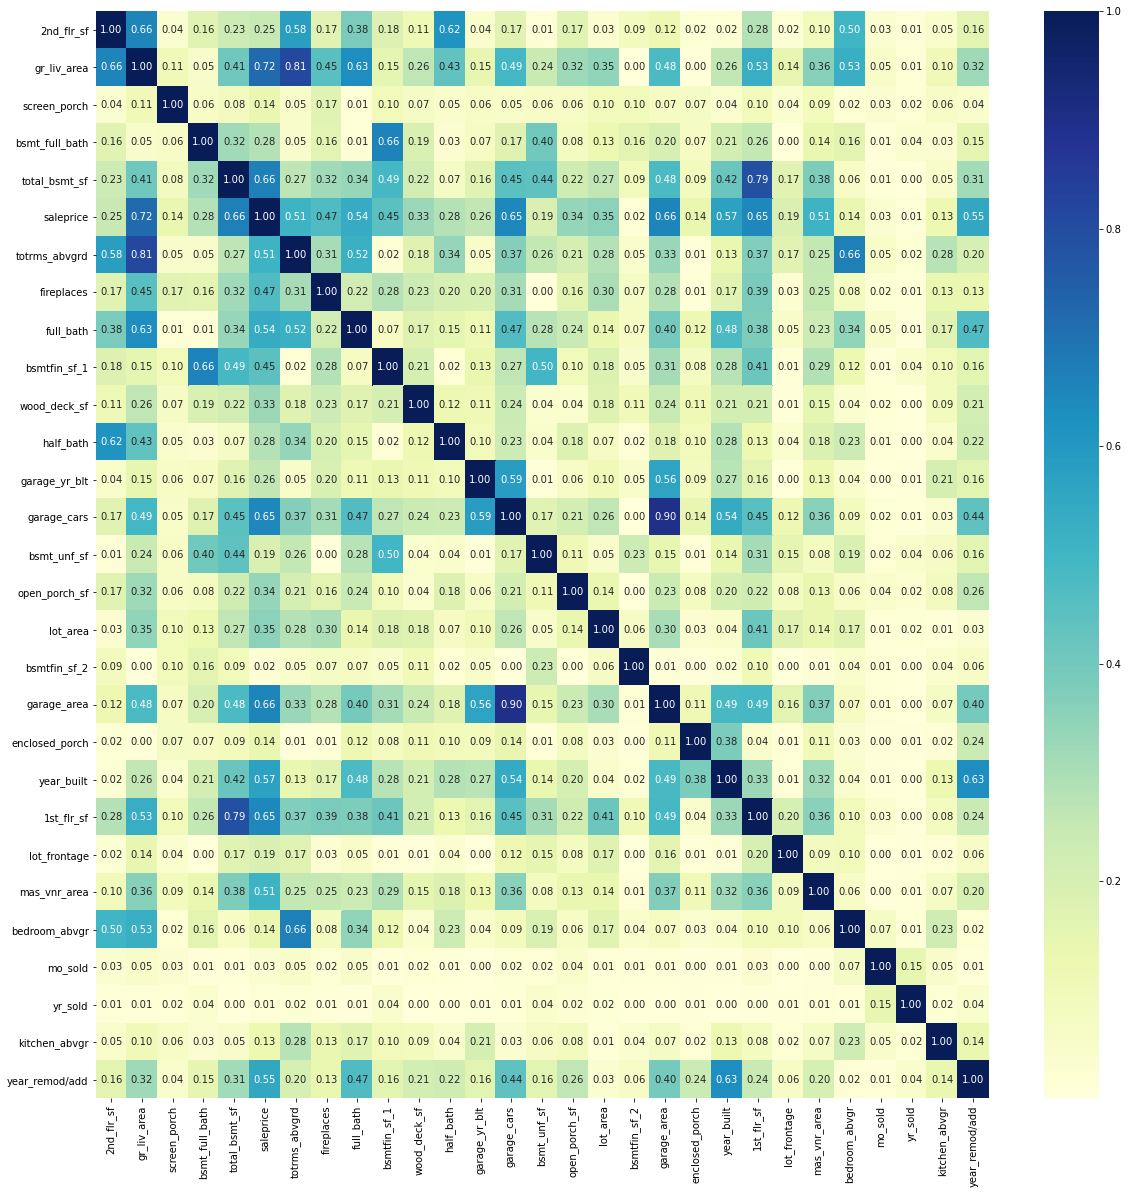

In [118]:
#heatmap for all discrete and continuous features (refer to 2nd
#heatmap below for zoomed in version)
plot_heatmap(train, discrete_cols + cont_cols, dropped_cols)

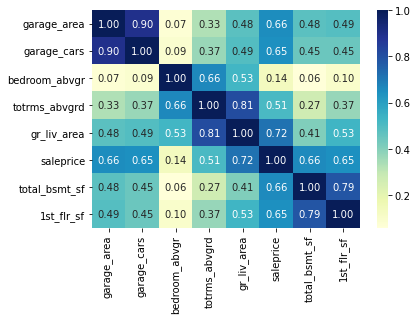

In [119]:
#plotting only the values of stronger correlation magnitudes (darker colours)
#from the above heatmap

discr_cont_combined = train[['garage_area',
                             'garage_cars',
                             'bedroom_abvgr',
                             'totrms_abvgrd',
                             'gr_liv_area',
                             'saleprice',
                             'total_bsmt_sf',
                             '1st_flr_sf'
                            ]]

sns.heatmap(discr_cont_combined.corr(),
            annot=True,
            cmap='YlGnBu',
            fmt=".2f");


In [120]:
train.drop(columns=['total_bsmt_sf','garage_cars'], inplace=True)

## **Additional plots**: ##

**Box & count plots for year sold & month sold:**
Volume of sales were consistent throughout the years of 2006 to 2009, which is surprising since the housing market in the US crashed in 2008. 
Spillover effects only started to happen in Iowa in 2010.
[Source(page 6)](https://ppc.uiowa.edu/sites/default/files/ag_foreclosure_october_2014.pdf')
Despite this, sale prices over the years of 2006 to 2010 remained fairly consistent with similar interquartile ranges. Thus it would make sense to **drop the year_sold feature.**


Highest volume of sales took place over the months of April to August (specifically June & July, peak summer period). We will not drop this feature as the prices vary slightly over the months.

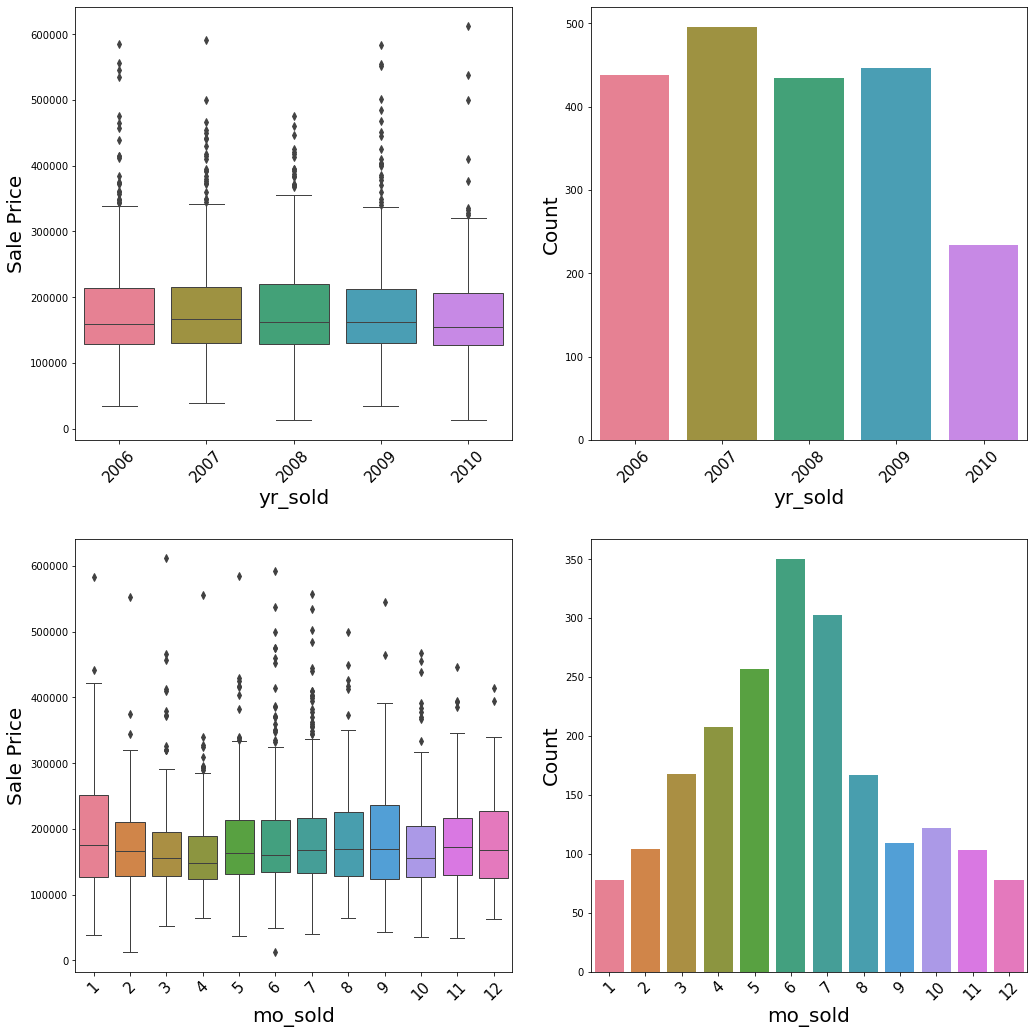

In [121]:
features_year_mo = ['yr_sold','mo_sold']
subplot_boxcountplot(train, features_year_mo, figsize=(15,15));

In [122]:
#dropping year sold col
train.drop(columns='yr_sold',inplace=True)

In [123]:
train.to_csv('./datasets/train_cleaned.csv')

In [124]:
train.shape

(2047, 56)